In [1]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme(style="ticks")

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

In [3]:
plt.rcParams["figure.figsize"] = (20,5)

# Combine Downloaded Data

In the data gathering step, we have created 13 JSON file downloaded from bazaarvoice API. Here we combine all JSON into two parquet files.
- Products (The aggregated reviews for a given product)
    - Total Reviews
    - Total Reviews breakdown into 5 stars
    - IsRecommended indicator

- Reviews (The individual reviews given by a user)
    - FirstSubmissionTime
    - Rating
    - ContextData: eye color, hair color, etc.
    
We can skip this step by directly importing the result file in the next section.

In [3]:
#get review details
def get_review_level_df(product_id,file_name):
    review_level_list = ['Id','ProductId','Rating','Title','ReviewText', 'IsRecommended','SubmissionTime',
                        'ContextDataValues.skinType.ValueLabel','ContextDataValues.eyeColor.ValueLabel','ContextDataValues.hairColor.ValueLabel',
                        'ContextDataValues.skinTone.ValueLabel','ContextDataValues.age.ValueLabel', 'ContextDataDistribution.skinConcerns.ValueLabel']
    df = pd.json_normalize(file_name[product_id][1])
    for i in review_level_list:
        if i not in df:
            df[i] = np.nan
    df_review_level = df.loc[:,review_level_list]
    df_review_level['Product_id_original'] = product_id
    return df_review_level

In [4]:
#get review_product 
def get_review_product_df(product_id,file_name):
    review_product_list = ['AverageOverallRating','FirstSubmissionTime', 'RecommendedCount', 'NotRecommendedCount','RatingDistribution',
                           'ContextDataDistribution.age.Values','ContextDataDistribution.skinType.Values','ContextDataDistribution.skinConcerns.Values',
                           'ContextDataDistribution.skinTone.Values','ContextDataDistribution.eyeColor.Values', 
                           'ContextDataDistribution.hairColor.Values']
    
    df = pd.DataFrame(file_name[product_id][0])  
    df= df.transpose().reset_index()
    df['Product_id']=df['Id']
    df['Product_id_original'] = product_id
    df_header_list=['Product_id_original', 'Product_id','Name','Brand','BrandExternalId','CategoryId','TotalReviewCount','ReviewStatistics']
    df_header = df.loc[:,df_header_list].copy()
    
    df = pd.json_normalize(df['ReviewStatistics'])
    for i in review_product_list:
        if i not in df:
            df[i] = np.nan
    df_review_product = df.loc[:,review_product_list]
    
    df_review_product = pd.concat([df_header, df_review_product], axis = 1)
    
    return df_review_product

In [5]:
#extract all product
def extract_all_product(file_name):
    products = list(file_name.keys())
    
    review_product_lst = []
    review_level_lst = []
    
    for product_id in products:
#         print(product_id)
        if file_name[product_id] != [[], []] and file_name[product_id] != [None, None]:
            tmp1 = get_review_product_df(product_id,file_name)
            review_product_lst.append(tmp1)
            tmp2 = get_review_level_df(product_id,file_name)
            review_level_lst.append(tmp2)
    
    df_review_product = pd.concat(review_product_lst)
    df_review_level = pd.concat(review_level_lst)
    return [df_review_product, df_review_level]

In [6]:
product_lst = []
review_lst = []
files = ['scraper_result'+str(i+1) for i in range(0, 13)]

for file in tqdm(files):
    file12 = None
    with open(f'data/{file}.json', 'rb') as file:
        file12 = json.load(file)
    
    df_review_product, df_review_level = extract_all_product(file12)
    product_lst.append(df_review_product)
    review_lst.append(df_review_level)
    del file12

100%|██████████| 13/13 [32:57<00:00, 152.15s/it]


In [7]:
df_product = pd.concat(product_lst)
df_review = pd.concat(review_lst)

In [ ]:
# To reduce memory
del product_lst
del review_lst

In [8]:
len(df_product)

14789

In [9]:
len(df_review)

2700551

## Remove duplicated lines

SKU_id is one level of details below Product_id. It means the same product may have different variant: package size, color, etc.
However, the review and product information is the same for SKUs in a given product id.
Thus, we need to remove duplicated lines.

In [ ]:
df_product = df_product[~df_product.duplicated(subset = ['Product_id_original'])]

In [ ]:
df_reviews = df_reviews[~df_reviews.duplicated()]

## Save to files
For easy to re-import

In [ ]:
df_product.to_pickle('data/all_products_no_dup.pkl')

In [ ]:
df_reviews.to_pickle('data/all_reviews_no_dup.pkl')

# Re-import combined data

In [156]:
# Original Kaggle File
df_product_list = pd.read_csv('data/sephora_website_dataset.csv') # total of 9168 products

In [157]:
df_product_list.shape

(9168, 21)

In [158]:
# Webscrap products from previous steps
df_product = pd.read_pickle('data/all_products_no_dup.pkl') # product scraped 4379 products 

In [159]:
#total product scrapped
df_product.shape

(4379, 19)

In [160]:
# Webscrap reviews from previous steps
df_reviews = pd.read_pickle('data/all_reviews_no_dup.pkl')

In [161]:
df_reviews.shape

(2574690, 14)

# Data Transformation - df_product
## Create new categories

In [170]:
#add Product ID to df_product_list. it is from the URL. Unique ID for each product (per web page )
df_product_list['Product_id'] = df_product_list['URL'].str.findall('P[0-9]{4,15}').apply(lambda x: x[0])

In [171]:
def create_category_level1_and_level2_map():
    'Use manual created category to map the products into categories.'
    # Product Hierarchy created manually
    df_category_map = pd.read_csv('data/category_map.csv')
    mapper1 = df_category_map.set_index("category")['Re_category_level1'].to_dict()
    mapper2 = df_category_map.set_index("category")['Re_category_level2'].to_dict()   
    return (mapper1, mapper2)

In [172]:
mapper1, mapper2 = create_category_level1_and_level2_map()

In [173]:
#map category- the category in product list is in the lowerest level. We map them to the highest level based on Sephora website
# we also create a lower level.
df_product_list['category_level1']= df_product_list['category'].map(mapper1)
df_product_list['category_level2']= df_product_list['category'].map(mapper2)

In [174]:
def create_product_id_level1_and_level2_map(df_product_list):
    # set product id as the index to create mapper for df_review (key is the product id)
    df_product_list2=df_product_list.set_index("Product_id")
    mapper_product_category_1 = df_product_list2['category_level1'].to_dict()
    mapper_product_category_2 = df_product_list2['category_level2'].to_dict()
    return (mapper_product_category_1, mapper_product_category_2)

In [175]:
mapper_product_category_1, mapper_product_category_2 = create_product_id_level1_and_level2_map(df_product_list)

In [176]:
#check if Kaggle data has any duplication 
df_product_list[df_product_list.duplicated(subset = ['Product_id'])]

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,URL,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,category_level1,category_level2,Product_id


## Create combined product dataframe 
from two product related dataframes (2020 and 2021)
- Dataframe1 2020: Kaggle data snapshot at April 2020
- Dataframe2 2021: Webscrap data snapshot at April 2021

DF contains: 'Product_id','name','size','brand','category', 'category_level1','category_level2','number_of_reviews_2020', 'rating_2020','number_of_reviews_2021', 'rating_2021','love','price','value_price','URL'

In [177]:
def create_product_df_2020(df_product_list):
    #how to get the data in scope:  due to the limite, we limit the scope: rating above or equal to 4 and number of review above 50
    df_product_b42020 = df_product_list.loc[(df_product_list["rating"]>=4) & (df_product_list["number_of_reviews"]>=50),:].copy()
    #delete the wrong value approx. 20

    df_product_b42020['number_of_reviews_2020'] = df_product_b42020['number_of_reviews'] 

    df_product_b42020['rating_2020'] = df_product_b42020['rating'] 

    df_product_b42020_temp=df_product_b42020[['Product_id','name','size','brand','category',
                                              'category_level1','category_level2','number_of_reviews_2020',
                                              'rating_2020','love','price','value_price','URL']].copy()
    return df_product_b42020_temp

In [178]:
def create_product_df_2021(df_product, df_product_b42020_temp):
    #selecte products in the scope(3960 in product_b4_2020; 3902 products after2020.)
    df_product_af2020=df_product.loc[df_product['Product_id_original'].isin(df_product_b42020_temp['Product_id'])].copy()

    #Rename the columns 
    df_product_af2020['number_of_reviews_2021']=df_product_af2020['TotalReviewCount']
    df_product_af2020['rating_2021']=df_product_af2020['AverageOverallRating']
    df_product_af2020_temp = df_product_af2020[["Product_id_original","number_of_reviews_2021",'rating_2021','FirstSubmissionTime']].copy()

    return df_product_af2020_temp

In [179]:
def combine_two_product_df(df_product_b42020_temp, df_product_af2020_temp):
    #merge the data frame product_af_2020 and product_b4_2020
    df_product_2020_2021_temp = pd.merge(df_product_af2020_temp,df_product_b42020_temp, left_on = 'Product_id_original', right_on = 'Product_id', how = 'left', indicator = True)
    df_product_2020_2021_temp['_merge'].value_counts()

    #selected needed columns
    df_product_2020_2021 = df_product_2020_2021_temp[['Product_id','name',"size","brand","category",'category_level1','category_level2',"price",'value_price','URL','love','FirstSubmissionTime',
                               'number_of_reviews_2021','number_of_reviews_2020','rating_2021','rating_2020']].copy()
    df_product_2020_2021['number_of_reviews_2021'] =df_product_2020_2021['number_of_reviews_2021'].astype(int)
    
    return df_product_2020_2021

In [180]:
df_product_b42020_temp = create_product_df_2020(df_product_list)
df_product_af2020_temp = create_product_df_2021(df_product, df_product_b42020_temp)
df_product_2020_2021 = combine_two_product_df(df_product_b42020_temp, df_product_af2020_temp)

In [181]:
# There are 58 products have no reviews in April 2021: 3960->3902; 
# Reasons: products no longer existed or Sephera has clear all reviews of the product
# 3902 products are the final products in this analysis 
df_product_b42020_temp.shape, df_product_af2020_temp.shape, df_product_2020_2021.shape

((3960, 13), (3902, 4), (3902, 16))

## Explore the combined dataframe

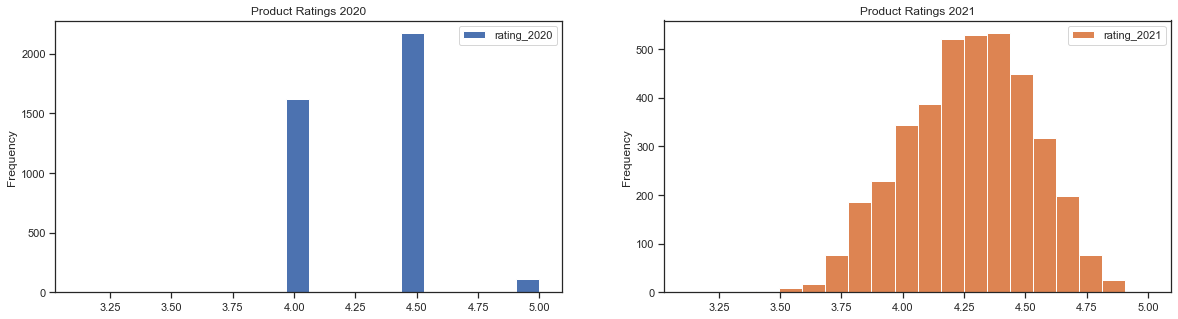

In [182]:
df_product_2020_2021[['rating_2020', 'rating_2021']].plot(kind = 'hist', bins = 20, subplots = True, layout = (1, 2), 
                                                          title = ['Product Ratings 2020', 'Product Ratings 2021']);
# The 2020 Reviews are from Kaggle. The data do not have same digit as 2021.
# We selected product ratings >=4 in 2020. However in 2021, the rating of certain products decreaed.

## New Features Creation

- **product_life**-> this will help us to calcuate the average number of reviews per year 
- **product_life above 1 year** and **product _life above 2 years **
- there are 14 products are new/upgraded. They have reviews before 2020.4. however, there is some update, the first submission date is after 2020.4. Therefore, we treated them as new products launched during pandamic. 

In [183]:
#Feature1: product life
df_product_2020_2021['product_life'] = (pd.to_datetime("2021-04-2")-pd.to_datetime(df_product_2020_2021["FirstSubmissionTime"]).dt.tz_localize(None))/pd.Timedelta('365D')

<AxesSubplot:ylabel='Frequency'>

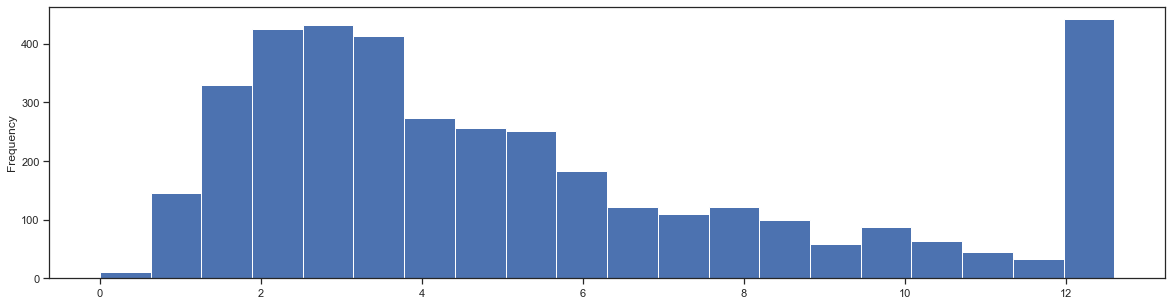

In [184]:
df_product_2020_2021['product_life'].plot(kind = 'hist', bins = 20)

note that there are some product has less than one year product life. This is due to the update of the product. 
The product has been updated, therefore, the reviews were also updated accordingly

In [185]:
#Feature2: tag product_life more than 1 year 
df_product_2020_2021['product_life_above_1'] = df_product_2020_2021['product_life'].\
                                               apply(lambda x: True if x >=1 else False)

In [186]:
#Feature3: tag product_life more than 2 year 
df_product_2020_2021['product_life_above_2'] = df_product_2020_2021['product_life'].\
                                               apply(lambda x: True if x >=2 else False)

# Data Transformation - df_reviews
## Time cleaning
combine with review data to calcuate the review numbers and rating during pandamic and b4 pandamic 

In [187]:
#convert review_submission_time to date format
df_reviews['review_submission_time']=pd.to_datetime(df_reviews["SubmissionTime"]).dt.tz_localize(None)

In [188]:
df_reviews["review_submission_time_d"] = pd.to_datetime(df_reviews["review_submission_time"]).dt.floor('D')

## Create 2020 and 2021 Product review details

In [189]:
def create_product_reviews_2021(df_reviews):
    #to count the # reviews per product during pandamic, we select the review_submision time after 2020-04-01 
    df_reviews_2021 = df_reviews.loc[df_reviews['review_submission_time']>= pd.to_datetime("2020-04-01"),:].copy()

    #groupby product id
    df_reviews_2021_temp = df_reviews_2021.groupby('Product_id_original').agg({"Rating": "mean", "Id": "count",'review_submission_time':'min'})\
    .reset_index().rename(columns = {"Product_id_original":'Product_id', 'Rating':'r_Rating_avg_2021',\
                                     'Id':'r_Review_count_2021','review_submission_time':'r_Submission_min_2021'})

    # first filter all submission time after 2020-4-1, then filter the min submission time is before 2020-5-1
    # there are the product that have full reviews of 2020-4 to 2021 
    df_reviews_2021_temp_1year = df_reviews_2021_temp[df_reviews_2021_temp['r_Submission_min_2021']< pd.to_datetime('2020-05-01')]
    return df_reviews_2021_temp_1year

In [190]:
df_reviews_2021_temp_1year = create_product_reviews_2021(df_reviews)

In [191]:
df_reviews_2021_temp_1year.head(2)

,Product_id,r_Rating_avg_2021,r_Review_count_2021,r_Submission_min_2021
0,P04546871,4.203704,54,2020-04-01 18:47:53
1,P04897543,4.031915,94,2020-04-04 03:09:44


In [192]:
products_above_1yr = df_product_2020_2021.product_life_above_1.sum()

In [193]:
products_above_1yr
# There are 3888 products with product life >2 years

3888

In [194]:
products_above_1yr/ len(df_product_2020_2021)
# 99% products have product life more than 1 year. 

0.9964120963608406

In [195]:
review_exists = df_product_2020_2021.Product_id.isin((df_reviews_2021_temp_1year.Product_id))

In [196]:
sum(review_exists) / len(review_exists)
# However, due to the limit of scraping (latest 3100 review), the review data will only cover 84%. 
# The rest 16% we will fillna with (review count 2021 - review count 2020) and rating 2021

0.8441824705279344

In [197]:
def create_product_reviews_2020(df_reviews):
    df_reviews_2020 = df_reviews.loc[(df_reviews['review_submission_time']>= pd.to_datetime("2019-04-01")) &\
                                     (df_reviews['review_submission_time']< pd.to_datetime("2020-04-01")) ,:].copy()

    df_reviews_2020_temp = df_reviews_2020.groupby('Product_id_original').agg({"Rating": "mean", "Id": "count",'review_submission_time':'min'})\
    .reset_index().rename(columns = {"Product_id_original":'Product_id', 'Rating':'r_Rating_avg_2020',\
                                     'Id':'r_Review_count_2020','review_submission_time':'r_Submission_min_2020'})

    df_reviews_2020_temp_2year = df_reviews_2020_temp[df_reviews_2020_temp['r_Submission_min_2020']< pd.to_datetime('2019-05-01')]
    return df_reviews_2020_temp_2year

In [198]:
df_reviews_2020_temp_2year = create_product_reviews_2020(df_reviews)

In [199]:
df_reviews_2020_temp_2year.shape

(2878, 4)

In [200]:
products_above_2yrs = df_product_2020_2021.product_life_above_2.sum()

In [201]:
products_above_2yrs
# There are 3319 products with product life >2 years

3319

In [202]:
products_above_2yrs/ len(df_product_2020_2021)
# 85% products have product life more than 2 years. 

0.8505894413121476

In [203]:
review_exists = df_product_2020_2021.Product_id.isin((df_reviews_2020_temp_2year.Product_id))

In [204]:
sum(review_exists) / len(review_exists)
# However, due to the limit of scraping (latest 3100 review), the review data will only cover 70%. 
# The rest 15% we will fillna with (review count aveverage 2020) and rating 2020

0.703997949769349

In [205]:
df_reviews_2020_temp_2year.head(2)

,Product_id,r_Rating_avg_2020,r_Review_count_2020,r_Submission_min_2020
0,P04546871,4.028881,277,2019-04-01 01:47:14
1,P04897543,3.763713,237,2019-04-02 19:32:55


# Merge three dataframe
- df_product_2020_2021 and 
- df_reviews_2021_temp_1year(during the pandamic) and 
- df_reviews_2020_temp_2year (before pandamic)

In [206]:
def merge_review_to_product(df_product_2020_2021, df_reviews_2021_temp_1year, df_reviews_2020_temp_2year):

    assert df_reviews_2021_temp_1year.Product_id.nunique() == len(df_reviews_2021_temp_1year)
    assert df_reviews_2020_temp_2year.Product_id.nunique() == len(df_reviews_2020_temp_2year)
    
    df_product_review_temp1 = pd.merge(df_product_2020_2021, df_reviews_2021_temp_1year, on = 'Product_id', how = "left")
#     df_product_review_temp2_list = ['Product_id','name',"size","brand","category","category_level1","category_level2","price",'value_price','URL','love',
#                                 'FirstSubmissionTime','product_life','product_life_above_1','product_life_above_2',
#                                 'number_of_reviews_2021','number_of_reviews_2020',
#                                 'rating_2021','rating_2020',
#                                  'r_Submission_min_2021']

#     df_product_review_temp2= df_product_review_temp1.loc[:,df_product_review_temp2_list].copy()
    df_product_review_temp3 = pd.merge(df_product_review_temp1, df_reviews_2020_temp_2year, on = 'Product_id', how = "left")
    return df_product_review_temp3

In [207]:
df_product_review = merge_review_to_product(df_product_2020_2021, df_reviews_2021_temp_1year, df_reviews_2020_temp_2year)

## New Features Creation

- Calculated_Rating_avg_2020-2021
- number_of_reviews_2021_pandamic_calculated

**'number_of_reviews_2021_pandamic'**:  #review 2021 (our scraped data)- #reivew 2020 (data download from Kaggle)
    - later we did a cross validation wiht the review data we scraped. We counted the # reviews per product from 2020-4 -2021-4, however, noticed that there are some discrepency. For example, P378716-CAVIAR Anti-Aging- Replenishing Moisture CC Cream: in our calcuation, the number of reivews posted in 2020-2021 is 70. however, if we use review 2020 (data download from Kaggle), the number is 679. We validated in the websiete and confirmed that 70 is the correct number. We could not figure out the exact reason. It seems that the webiste is updated sometimes. Some reivews might be deleted, and some reviews might be released after, which caused the inconsistancy if we download data in different time. Therefore, we decided to use the latest data we scraped. In case of missing data, we will fill in with the data donwload from Kaggle. 
- **number_of_reviews_avg_2021** and **number_of_reviews_avg_2020**

In [248]:
def create_new_features_on_merged_data(df):
    '''There are 4 variables to iterate through:
    1. Ratings vs. Reviews
    2. Period vs. up-to
    3. Adjusted vs. Original (adjusted is fillna)
    4. Normalized vs. Original (Normalized is per year original is up-to)
    5. 2021, 2020
    '''
    
    for measurement in ['Rating', 'Review_count']:
        if measurement == 'Rating':
            # If rating then we do not need to normalize or adjust since the avg rating is reflecting a general opinion
            df['Rating_up_to_2020'] = df['rating_2020']
            df['Rating_up_to_2021'] = df['rating_2021']
            df['Rating_period_2020-2021'] = df['r_Rating_avg_2021'].fillna(df['Rating_up_to_2020'])
            df['Rating_period_2019-2020'] = df['r_Rating_avg_2020'].fillna(df['Rating_up_to_2021'])
        if measurement == 'Review_count':
            # We need to adjust (prioritize with fresher data and fillna with older data) and normalize (up-to convert to period by dividing life time)
            df['Review_count_up_to_2020'] = df['number_of_reviews_2020']
            df['Review_count_up_to_2021'] = df['number_of_reviews_2021']
            
            df['Review_count_period_2020-2021'] = (df['r_Review_count_2021'].fillna(df['Review_count_up_to_2021'] - df['Review_count_up_to_2020'])).clip(0,None)
            df['Review_count_up_to_2020_adjusted'] = (df['number_of_reviews_2021'] - df['Review_count_period_2020-2021']).clip(0,None)
            
            # If product_life <1 then adjust to 1
            # If the result normalized review count <0 then adjust to 0
#             df['Review_count_up_to_2020_normalized'] = (df['Review_count_up_to_2020_adjusted'].div( (df['product_life'] - 1).clip(1,None) )).clip(0,None)
            df["Review_count_up_to_2020_normalized"] = df['product_life_above_2'].astype('bool') * (df['Review_count_up_to_2020']/\
                                                           (df['product_life']-1))
            df["Review_count_up_to_2020_normalized"] = df["Review_count_up_to_2020_normalized"].clip(0, None)
#             df['Review_count_up_to_2021_normalized'] = (df['Review_count_up_to_2021'].div( (df['product_life'].clip(1,None) ) )).clip(0,None)
            df["Review_count_up_to_2021_normalized"] = np.where(df["product_life_above_1"]== True, df['Review_count_up_to_2021']/(df['product_life']),\
                                                                 df["Review_count_up_to_2021"])
            df['Review_count_period_2019-2020'] = df['r_Review_count_2020'].fillna(df['Review_count_up_to_2020_normalized'])
            
    return df

In [249]:
df_product_review = create_new_features_on_merged_data(df_product_review)

In [250]:
df_product_review['number_of_reviews_avg_diff'] = df_product_review['Review_count_up_to_2021_normalized'] - df_product_review['Review_count_up_to_2020_normalized']

In [251]:
final_cols = ['Product_id','name',"size","brand","category","category_level1","category_level2",\
                                "price",'value_price','URL','love',
                                'FirstSubmissionTime','product_life','product_life_above_1','product_life_above_2',
                                'Review_count_up_to_2021','Review_count_up_to_2020_adjusted','Review_count_up_to_2020',
                                'Review_count_up_to_2021_normalized', 'Review_count_up_to_2020_normalized', 'number_of_reviews_avg_diff',
                                'Rating_up_to_2021', 'Rating_up_to_2020',
                                'Review_count_period_2020-2021','Review_count_period_2019-2020',
                                'Rating_period_2020-2021','Rating_period_2019-2020',
                                 'r_Submission_min_2021']

In [252]:
df_product_review_finall_all = df_product_review.loc[:,final_cols].copy()

In [253]:
df_product_review_finall_all.describe()

,price,value_price,love,product_life,Review_count_up_to_2021,Review_count_up_to_2020_adjusted,Review_count_up_to_2020,Review_count_up_to_2021_normalized,Review_count_up_to_2020_normalized,number_of_reviews_avg_diff,Rating_up_to_2021,Rating_up_to_2020,Review_count_period_2020-2021,Review_count_period_2019-2020,Rating_period_2020-2021,Rating_period_2019-2020
count,3902.000000,3902.000000,3.902000e+03,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000,3902.000000
mean,45.323232,45.915210,3.150538e+04,5.356421,743.055613,646.854434,585.184777,171.047577,129.352261,41.695316,4.267932,4.307022,96.201179,92.459349,4.075127,4.181641
std,36.530425,37.312424,5.977794e+04,3.542106,1422.549170,1332.090064,1234.555546,274.520395,249.570936,198.112336,0.255770,0.271800,214.559076,195.144406,0.503273,0.392273
min,2.000000,2.000000,0.000000e+00,0.000977,4.000000,0.000000,50.000000,4.000000,0.000000,-1320.973709,3.120300,4.000000,0.000000,0.000000,1.000000,1.000000
25%,25.000000,25.000000,6.825000e+03,2.614936,135.250000,106.000000,108.000000,32.242245,18.595806,-11.475893,4.087575,4.000000,10.000000,12.000000,3.848864,3.970479
50%,34.000000,34.000000,1.420000e+04,4.181428,292.000000,230.000000,231.000000,72.877798,50.781806,-2.154740,4.280800,4.500000,29.000000,32.257952,4.127333,4.230769
75%,54.000000,54.000000,3.250000e+04,7.442771,747.000000,612.000000,613.000000,191.826560,136.007243,28.490532,4.455050,4.500000,84.000000,83.000000,4.453373,4.444444
max,549.000000,549.000000,1.300000e+06,12.602139,19576.000000,19473.000000,19000.000000,4524.015675,5844.989384,3506.265519,4.921900,5.000000,4236.000000,3210.186783,5.000000,5.000000


In [254]:
df_product_review_finall_all[df_product_review_finall_all['number_of_reviews_avg_diff'] == df_product_review_finall_all['number_of_reviews_avg_diff'].max()]

,Product_id,name,size,brand,category,category_level1,category_level2,price,value_price,URL,love,FirstSubmissionTime,product_life,product_life_above_1,product_life_above_2,Review_count_up_to_2021,Review_count_up_to_2020_adjusted,Review_count_up_to_2020,Review_count_up_to_2021_normalized,Review_count_up_to_2020_normalized,number_of_reviews_avg_diff,Rating_up_to_2021,Rating_up_to_2020,Review_count_period_2020-2021,Review_count_period_2019-2020,Rating_period_2020-2021,Rating_period_2019-2020,r_Submission_min_2021
346,P448162,Boi-ing Cakeless Concealer,0.17 oz/ 5.0 mL,Benefit Cosmetics,Concealer,Makeup,Concealer,22.0,22.0,https://www.sephora.com/product/boi-ing-cakele...,20600,2019-08-15T13:14:23.000+00:00,1.631365,True,False,5720,5592.0,5000,3506.265519,0.0,3506.265519,4.3122,4.5,128.0,0.0,3.5625,4.3122,2020-04-03 08:46:41


# Analyze and plot for EDA

### Two years combine
the scope is only the 85% products have product life more than 2 years. 
### For 2019-2020
- However, due to the limit of scraping (latest 3100 review), the review data will only cover 68%. 
-T he rest 17% we will fillna with (review count aveverage 2020) and rating 2020

### For 2020-2021
- However, due to the limit of scraping (latest 3100 review), the review data will only cover 83d%. 
- The rest 16% we will fillna with (review count 2021 - review count 2020) and rating 2021

<AxesSubplot:ylabel='Frequency'>

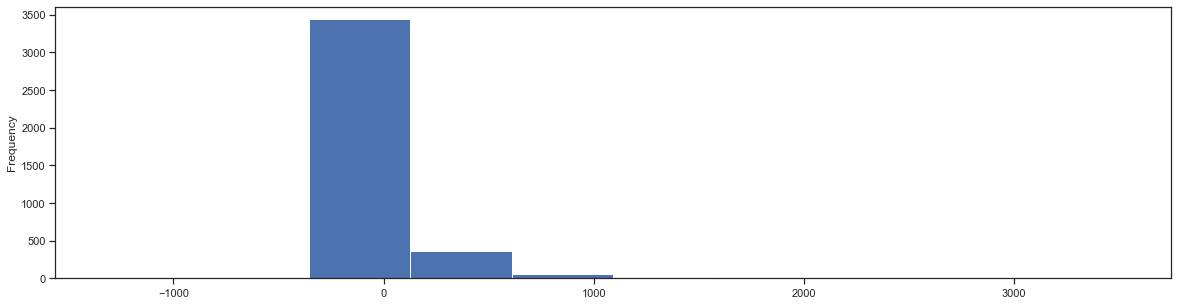

In [255]:
df_product_review_finall_all['number_of_reviews_avg_diff'].plot(kind = "hist")

Seems most products have less reviews during pandamic.

<AxesSubplot:ylabel='Frequency'>

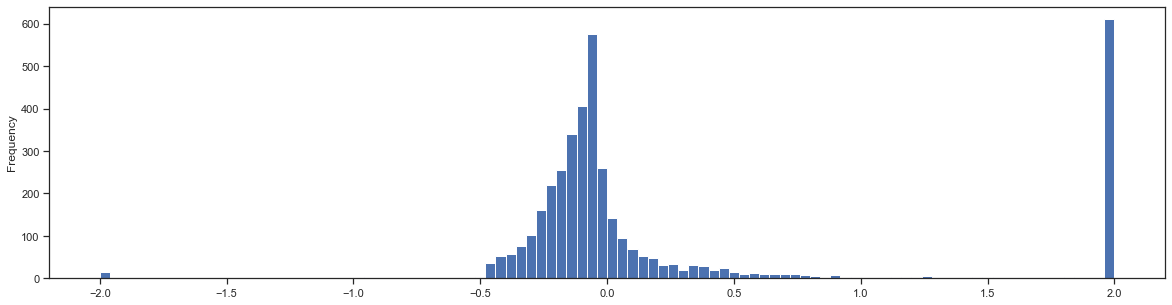

In [260]:
(df_product_review_finall_all['number_of_reviews_avg_diff'].div(df_product_review_finall_all['Review_count_up_to_2020_normalized'])).clip(-2,2).plot(kind = "hist", bins = 100)

In [262]:
df_category = (df_product_review_finall_all.set_index('category_level1')['number_of_reviews_avg_diff'].\
               div(df_product_review_finall_all.set_index('category_level1')['Review_count_up_to_2020_normalized'])).clip(-2,2)

In [87]:
#for i in df_category.index[:5]:
 #   plt.hist(df_category.loc[i], bins = 30, alpha = 0.2);
    

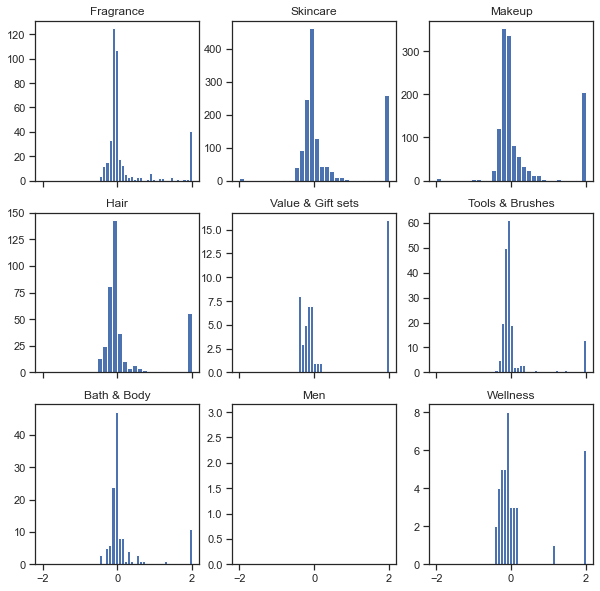

In [263]:
figure, axes = plt.subplots(3,3, figsize = (10,10), sharex = True)
for i,ax in zip(df_category.index.unique(),
            axes.reshape(-1)):
    ax.hist(df_category.loc[i], bins = 30);
    ax.set_title(i)

Seems all categories have less reviews during pandamic.

In [264]:
#Analyze product life more than 2 years. we can compare the before pandamic vs pandamic 
df_product_review_finall_all['2_year_product_review_diff'] = df_product_review_finall_all['Review_count_period_2020-2021']-\
                                                            df_product_review_finall_all['Review_count_period_2019-2020']


In [292]:
df_product_review_finall_all['2_year_product_rating_diff'] = df_product_review_finall_all['Rating_period_2020-2021']-\
                                                            df_product_review_finall_all['Rating_period_2019-2020']


## Category level analysis 

In [295]:
df_product_review_finall_all['category_level1'].value_counts()

Skincare             1393
Makeup               1288
Fragrance             405
Hair                  386
Tools & Brushes       182
Bath & Body           124
Value & Gift sets      49
Wellness               40
Nail                   23
Men                    12
Name: category_level1, dtype: int64

In [296]:
#df_product_review_finall_all['category_level2'].value_counts()

In [297]:
df_product_review_finall_all['brand'].value_counts()

SEPHORA COLLECTION    202
CLINIQUE              125
Fresh                  78
tarte                  72
Lancôme                70
                     ... 
SKYLAR                  1
Lab Series For Men      1
DL.MD                   1
Artis                   1
Commodity               1
Name: brand, Length: 276, dtype: int64

In [298]:
#df_product_review_finall_all[df_product_review_finall_all['brand'] == "La Mer"]

In [299]:
#df_product_review_finall_all.groupby('brand').agg({"price":'median'}).sort_values(by = "price", ascending = False)

In [300]:
df_product_review_finall_all.groupby('category_level1').agg({"price":'median'}).sort_values(by = "price", ascending = False)

,price
category_level1,
Fragrance,92.0
Skincare,39.5
Value & Gift sets,39.0
Wellness,32.5
Bath & Body,32.0
Makeup,29.0
Tools & Brushes,29.0
Hair,28.0
Men,25.0


In [301]:
#df_product_review_finall_all.groupby('category_level2').agg({"price":'median'}).sort_values(by = "price", ascending = False)

## dataframe to analyze two year product life 

In [302]:
#dataframe to analyze two year product life 
df_product_review_2_year = df_product_review_finall_all.loc[df_product_review_finall_all["product_life_above_2"]==True,:].copy()

In [303]:
#df_product_review_2_year.sort_values(by = 'number_of_reviews_2021_pandamic', ascending = False).head(30)

In [304]:
df_product_review_finall_all.sum()

Product_id                            P163604P307801P388670P405269P388770P388766P398...
name                                  ColoniaFico di AmalfiRosa NobileMediterranean ...
size                                  0.7 oz/ 20 mL5 oz/ 148 mL3.4 oz/ 101 mL1.7 oz/...
brand                                 Acqua Di ParmaAcqua Di ParmaAcqua Di ParmaAERI...
category                              ColognePerfumePerfumePerfumePerfumePerfumeLip ...
category_level1                       FragranceFragranceFragranceFragranceFragranceF...
category_level2                       FragranceFragranceFragranceFragranceFragranceF...
price                                                                            176851
value_price                                                                      179161
URL                                   https://www.sephora.com/product/colonia-P16360...
love                                                                          122933986
FirstSubmissionTime             

# Visualization - correlation price, like, number of review and rating 2020

In [305]:
df_splom = df_product_review_finall_all.loc[:,['product_life',"category_level1",'price','love','Review_count_up_to_2021','Rating_up_to_2021']]

In [306]:
df_heatmap = df_product_review_finall_all.loc[:,['product_life','price','love','Review_count_up_to_2021','Rating_up_to_2021']]

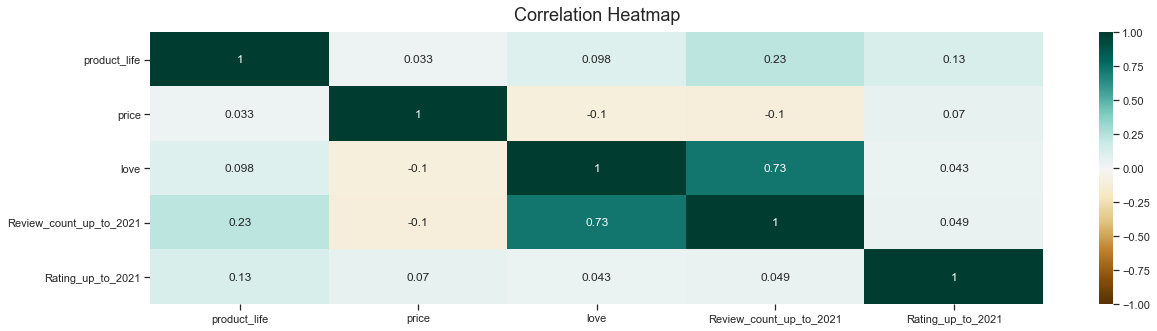

In [307]:
heatmap = sns.heatmap(df_heatmap.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [308]:
# df_splom['love']= np.log(df_splom['love'].clip(0.00000001, ))
# df_splom['number_of_reviews_2020'] = np.log(df_splom['number_of_reviews_2020'])
# df_splom['price'] = df_splom['price'].clip(0, 150)

In [309]:
df_splom.describe(percentiles = (0,0.98))

,product_life,price,love,Review_count_up_to_2021,Rating_up_to_2021
count,3902.000000,3902.000000,3.902000e+03,3902.000000,3902.000000
mean,5.356421,45.323232,3.150538e+04,743.055613,4.267932
std,3.542106,36.530425,5.977794e+04,1422.549170,0.255770
min,0.000977,2.000000,0.000000e+00,4.000000,3.120300
0%,0.000977,2.000000,0.000000e+00,4.000000,3.120300
50%,4.181428,34.000000,1.420000e+04,292.000000,4.280800
98%,12.598022,140.000000,1.934760e+05,4870.880000,4.739700
max,12.602139,549.000000,1.300000e+06,19576.000000,4.921900


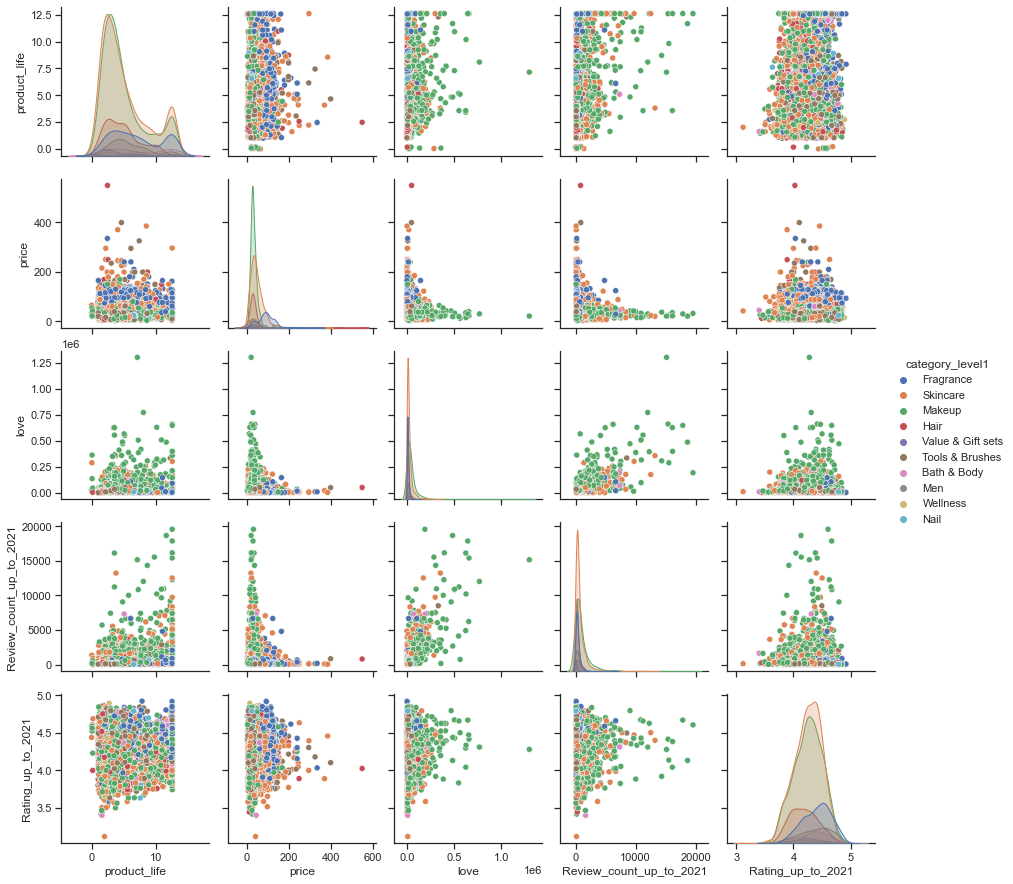

In [310]:
#df = sns.load_dataset("penguins")
sns.pairplot(df_splom, hue="category_level1")

## Analyzie in category level- product life above or equal to 2 years

In [311]:
df_product_review_2_year.groupby('category_level1')\
.agg({"price":'median', "Product_id":'count',"Review_count_period_2020-2021":["median",'mean','max','min','sum'],"2_year_product_rating_diff":"mean" })\
.apply(lambda x: np.round(x, 2))\
.sort_values(by = ("price",'median'), ascending = False)\
.style.bar(color = 'lightblue')

In [312]:
df_product_review_2_year.groupby('category_level2')\
.agg({"price":'median', "Review_count_period_2020-2021":["median",'mean','max','min','sum'],"2_year_product_rating_diff":"mean" })\
.apply(lambda x: np.round(x, 2))\
.sort_values(by = ("price",'median'), ascending = False)\
.style.bar(color = 'lightblue')

### Top 1 review product per category level 1

In [313]:
mapper3 = df_product_review_finall_all['name'].to_dict()

In [314]:
df_result = df_product_review_finall_all.groupby('category_level1')\
.agg({"Product_id":"count","price":'median', "2_year_product_review_diff":["mean",'max','min','sum', 'idxmax'],"2_year_product_rating_diff":"mean" })\
.apply(lambda x: np.round(x, 2))\
.sort_values(by = ("Product_id",'count'), ascending = False)

df_result[('2_year_product_review_diff', 'idxmax')] = df_result[('2_year_product_review_diff', 'idxmax')].map(mapper3)

df_result.style.bar(color = 'lightblue')

## visualize the matrix of reviews changed vs rating changed 

In [316]:
review_count = df_product_review_2_year['2_year_product_review_diff'].clip(-1000,1000)
rating = df_product_review_2_year['2_year_product_rating_diff']

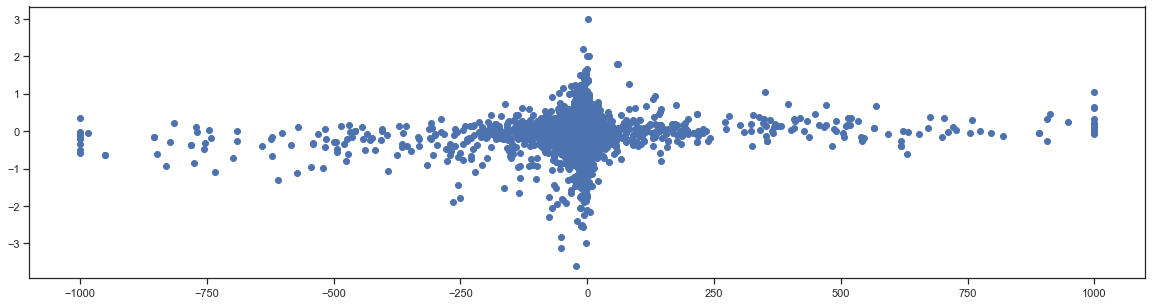

In [317]:
plt.scatter(review_count, rating)

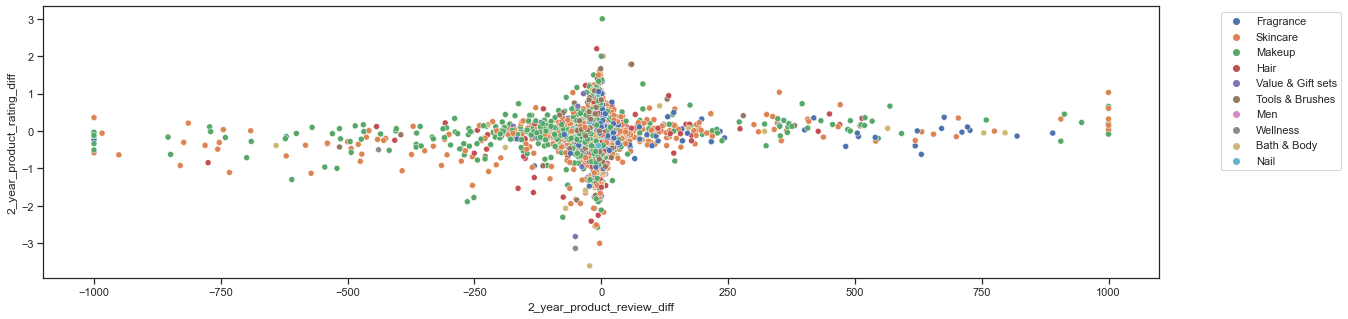

In [318]:
sns.scatterplot(data = df_product_review_2_year, x=review_count, y = rating, hue = 'category_level1');
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left');

# Select the products that can bring happiness to people during the covid-19. 

we build up a model to calcalate happiness score: we have five indicators, each indicator is normalized to [0,1], the happiness score is the sum of the five indicators. 

the five indicators are:
- number of reviews 2021
- number of rating 2021
- 2_year_product_review_diff
- 2_year_product_review_diff
- covid-19 related words mentioned in the review and happiness related word mentioned in the review 

In [315]:
final_cols = ['Product_id','name',"size","brand","category","category_level1","category_level2",\
                                "price",'value_price','URL','love',
                                'FirstSubmissionTime','product_life','product_life_above_1','product_life_above_2',
                                'Review_count_up_to_2021','Review_count_up_to_2020_adjusted','Review_count_up_to_2020',
                                'Review_count_up_to_2021_normalized', 'Review_count_up_to_2020_normalized', 'number_of_reviews_avg_diff',
                                'Rating_up_to_2021', 'Rating_up_to_2020',
                                'Review_count_period_2020-2021','Review_count_period_2019-2020',
                                'Rating_period_2020-2021','Rating_period_2019-2020',
                                 'r_Submission_min_2021']

In [324]:
df_reviews_2021 = df_reviews.loc[df_reviews['review_submission_time']>= pd.to_datetime("2020-04-01"),:].copy()

In [325]:
df_reviews_2021.head(2)

,Id,ProductId,Rating,Title,ReviewText,IsRecommended,SubmissionTime,ContextDataValues.skinType.ValueLabel,ContextDataValues.eyeColor.ValueLabel,ContextDataValues.hairColor.ValueLabel,ContextDataValues.skinTone.ValueLabel,ContextDataValues.age.ValueLabel,ContextDataDistribution.skinConcerns.ValueLabel,Product_id_original,review_submission_time,review_submission_time_d
0,173658866,P443401,2,Too similar and no lasting power,I bought this because I already love Arancia d...,False,2021-02-15T18:09:41.000+00:00,Combination,Blue,Blonde,Fair,NaN,NaN,P443401,2021-02-15 18:09:41,2021-02-15
1,173618877,P443401,1,None,Why is this 82$ when the value is lower? That ...,False,2021-02-14T17:22:53.000+00:00,Combination,Green,Blonde,Fair,NaN,NaN,P443401,2021-02-14 17:22:53,2021-02-14


In [326]:
def create_keywords_feature(df_reviews_2021, keywords):
    'Count the occurance of keywords in the data frame'
    df= df_reviews_2021.set_index(['review_submission_time_d', 'Product_id_original'])['ReviewText'].str.lower().str.contains(keywords)
    df = pd.DataFrame(df)
    df = df.reset_index()
    df = df.groupby('Product_id_original')['ReviewText'].sum()
    mapper = df.to_dict()
    return mapper

In [327]:
mapper_covid = create_keywords_feature(df_reviews_2021, 'covid|pandemic|virus')

In [328]:
mapper_happy = create_keywords_feature(df_reviews_2021, 'delight|joy|happy|happiness|pleasure|enjoy|relax|')

In [329]:
#Map to df
df_product_review_finall_all['#review_covid']=df_product_review_finall_all['Product_id'].map(mapper_covid).fillna(0)

In [330]:
df_product_review_finall_all['#review_happy']=df_product_review_finall_all['Product_id'].map(mapper_happy).fillna(0)

# Normalize the score

In [331]:
df_product_review_finall_all2 = df_product_review_finall_all.copy()

In [332]:
from sklearn.preprocessing import MinMaxScaler

In [333]:
minmax = MinMaxScaler()

In [342]:
indicator = ['love','Review_count_up_to_2021','2_year_product_review_diff','Rating_up_to_2021','2_year_product_rating_diff','#review_covid','#review_happy']

In [343]:
cols_numeric = df_product_review_finall_all2.select_dtypes(np.number).columns

In [344]:
df_result = minmax.fit_transform(df_product_review_finall_all2[cols_numeric])

In [345]:
df_product_review_finall_all_minmax = df_product_review_finall_all.copy()

In [346]:
df_product_review_finall_all_minmax[[i+'_min_max' for i in cols_numeric]] = df_result

In [347]:
weights = [0.5,1,1,1,1,0.25,0.25]

In [349]:
df_product_review_finall_all_minmax['score_weight']=df_product_review_finall_all_minmax[[i+'_min_max' for i in indicator]].dot(weights)

In [350]:
#df_product_review_finall_all_minmax['score']  = df_product_review_finall_all_minmax[[i+'_min_max' for i in indicator]].sum(axis = 1)

In [351]:
df_score = df_product_review_finall_all_minmax.sort_values(by = 'score_weight', ascending = False).groupby('category_level1').head(5)

In [352]:
df_score.head(2)

,Product_id,name,size,brand,category,category_level1,category_level2,price,value_price,URL,love,FirstSubmissionTime,product_life,product_life_above_1,product_life_above_2,Review_count_up_to_2021,Review_count_up_to_2020_adjusted,Review_count_up_to_2020,Review_count_up_to_2021_normalized,Review_count_up_to_2020_normalized,number_of_reviews_avg_diff,Rating_up_to_2021,Rating_up_to_2020,Review_count_period_2020-2021,Review_count_period_2019-2020,Rating_period_2020-2021,Rating_period_2019-2020,r_Submission_min_2021,2_year_product_review_diff,2_year_product_rating_diff,#review_covid,#review_happy,price_min_max,value_price_min_max,love_min_max,product_life_min_max,Review_count_up_to_2021_min_max,Review_count_up_to_2020_adjusted_min_max,Review_count_up_to_2020_min_max,Review_count_up_to_2021_normalized_min_max,Review_count_up_to_2020_normalized_min_max,number_of_reviews_avg_diff_min_max,Rating_up_to_2021_min_max,Rating_up_to_2020_min_max,Review_count_period_2020-2021_min_max,Review_count_period_2019-2020_min_max,Rating_period_2020-2021_min_max,Rating_period_2019-2020_min_max,2_year_product_review_diff_min_max,2_year_product_rating_diff_min_max,#review_covid_min_max,#review_happy_min_max,score_weight
2100,P420652,Lip Sleeping Mask,0.7 oz/ 20 g,LANEIGE,Lip Balms & Treatments,Skincare,Lip Skincare,20.0,20.0,https://www.sephora.com/product/lip-sleeping-m...,355400,2017-06-13T16:40:53.000+00:00,3.803575,True,True,13236,9000.0,9000,3479.883888,3210.186783,269.697105,4.3994,4.5,4236.0,3210.186783,4.500000,4.399400,NaT,1025.813217,0.100600,7.0,3100.0,0.032907,0.032907,0.273385,0.301766,0.676068,0.462178,0.472296,0.768998,0.54922,0.32952,0.709980,0.5,1.00000,1.000000,0.875000,0.849850,0.659848,0.560903,0.333333,1.000000,3.076824
3565,P2855,Blush,0.16 oz/ 4.8 g,NARS,Blush,Makeup,Blush,30.0,30.0,https://www.sephora.com/product/blush-P2855?ic...,646600,2008-08-28T15:35:00.000+00:00,12.600961,True,True,17876,17652.0,17000,1418.621982,1465.395865,-46.773883,4.6694,4.5,224.0,344.000000,4.473214,4.636628,2020-04-02 03:51:32,-120.000000,-0.163414,0.0,224.0,0.051188,0.051188,0.497385,0.999906,0.913141,0.906486,0.894459,0.312968,0.25071,0.26396,0.859847,0.5,0.05288,0.107159,0.868304,0.909157,0.398127,0.520920,0.000000,0.072258,2.958792


In [356]:
score_list = ['name','brand','category','category_level1','category_level2',
              'price','URL','score_weight','love','Review_count_up_to_2021','2_year_product_review_diff','Rating_up_to_2021','2_year_product_rating_diff','#review_covid','#review_happy']

In [357]:
df_score_final = df_score.loc[:,score_list].copy()

In [358]:
df_score_final.head()

,name,brand,category,category_level1,category_level2,price,URL,score_weight,love,Review_count_up_to_2021,2_year_product_review_diff,Rating_up_to_2021,2_year_product_rating_diff,#review_covid,#review_happy
2100,Lip Sleeping Mask,LANEIGE,Lip Balms & Treatments,Skincare,Lip Skincare,20.0,https://www.sephora.com/product/lip-sleeping-m...,3.076824,355400,13236,1025.813217,4.3994,0.100600,7.0,3100.0
3565,Blush,NARS,Blush,Makeup,Blush,30.0,https://www.sephora.com/product/blush-P2855?ic...,2.958792,646600,17876,-120.000000,4.6694,-0.163414,0.0,224.0
1953,Everlasting Liquid Lipstick,KVD Vegan Beauty,Lipstick,Makeup,Lipstick,21.0,https://www.sephora.com/product/everlasting-lo...,2.908521,1300000,15159,-195.000000,4.2792,0.242827,0.0,341.0
231,Original Loose Powder Mineral Foundation Broad...,bareMinerals,Foundation,Makeup,Foundation & Primer,32.0,https://www.sephora.com/product/bareminerals-o...,2.868408,191700,19576,-33.000000,4.6056,-0.011422,0.0,103.0
3154,Ultimate Sun Protector Lotion SPF 50+ Sunscreen,Shiseido,Face Sunscreen,Skincare,Sunscreen,49.0,https://www.sephora.com/product/shiseido-ultim...,2.792537,3900,2796,2515.000000,4.5483,0.000805,9.0,2515.0


In [359]:
#df_score_final.sort_values(by = ['category_level1','score_weight'], ascending = False)

# Review time series analysis 

In [360]:
df_reviews.head(2)

,Id,ProductId,Rating,Title,ReviewText,IsRecommended,SubmissionTime,ContextDataValues.skinType.ValueLabel,ContextDataValues.eyeColor.ValueLabel,ContextDataValues.hairColor.ValueLabel,ContextDataValues.skinTone.ValueLabel,ContextDataValues.age.ValueLabel,ContextDataDistribution.skinConcerns.ValueLabel,Product_id_original,review_submission_time,review_submission_time_d
0,173658866,P443401,2,Too similar and no lasting power,I bought this because I already love Arancia d...,False,2021-02-15T18:09:41.000+00:00,Combination,Blue,Blonde,Fair,NaN,NaN,P443401,2021-02-15 18:09:41,2021-02-15
1,173618877,P443401,1,None,Why is this 82$ when the value is lower? That ...,False,2021-02-14T17:22:53.000+00:00,Combination,Green,Blonde,Fair,NaN,NaN,P443401,2021-02-14 17:22:53,2021-02-14


In [361]:
#group by category, see the review changes per category

In [362]:
df_reviews_2021.head(2)

,Id,ProductId,Rating,Title,ReviewText,IsRecommended,SubmissionTime,ContextDataValues.skinType.ValueLabel,ContextDataValues.eyeColor.ValueLabel,ContextDataValues.hairColor.ValueLabel,ContextDataValues.skinTone.ValueLabel,ContextDataValues.age.ValueLabel,ContextDataDistribution.skinConcerns.ValueLabel,Product_id_original,review_submission_time,review_submission_time_d
0,173658866,P443401,2,Too similar and no lasting power,I bought this because I already love Arancia d...,False,2021-02-15T18:09:41.000+00:00,Combination,Blue,Blonde,Fair,NaN,NaN,P443401,2021-02-15 18:09:41,2021-02-15
1,173618877,P443401,1,None,Why is this 82$ when the value is lower? That ...,False,2021-02-14T17:22:53.000+00:00,Combination,Green,Blonde,Fair,NaN,NaN,P443401,2021-02-14 17:22:53,2021-02-14


In [363]:
df_reviews_2021['category_level1']=df_reviews_2021['ProductId'].map(mapper_product_category_1)
df_reviews_2021['category_level2']=df_reviews_2021['ProductId'].map(mapper_product_category_2)

In [364]:
df_reviews_2021["review_submission_time_d"] = pd.to_datetime(df_reviews_2021["review_submission_time"]).dt.floor('D')

In [365]:
df_reviews_2021_ts = df_reviews_2021.groupby(['review_submission_time_d',"category_level1"]).agg({"Id": 'count'}).reset_index()

In [366]:
df_reviews_2021_ts= df_reviews_2021_ts.set_index(["review_submission_time_d", 'category_level1']).unstack()

In [367]:
df_reviews_2021_ts.columns = [i[1] for i in df_reviews_2021_ts.columns]

In [368]:
#note that the two years data might not be comparable as the people might move from offline to online 

In [369]:
df_reviews_2021_ts.sum()

Bath & Body           10820.0
Fragrance             28982.0
Hair                  26535.0
Makeup                40058.0
Men                      56.0
Nail                    165.0
Skincare             158357.0
Tools & Brushes        4877.0
Value & Gift sets      2198.0
Wellness               2250.0
dtype: float64

In [370]:
df_reviews_2021_ts = df_reviews_2021_ts.resample('W').sum()

In [371]:
# df_reviews_2021_ts = df_reviews_2021_ts.rolling('7D').mean()

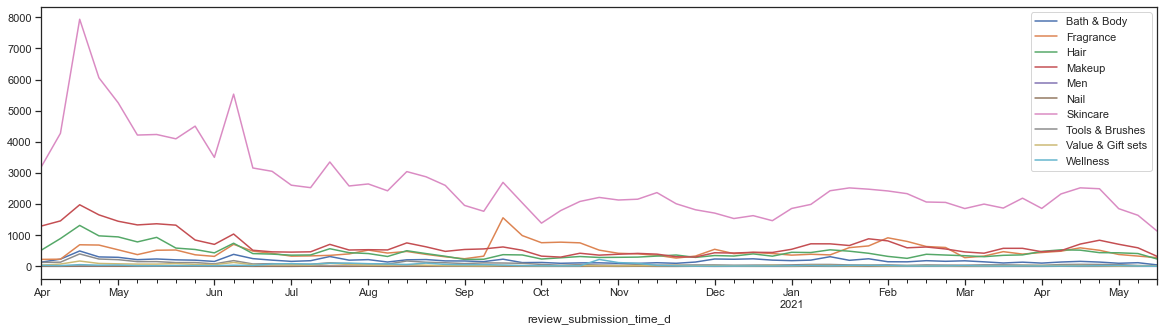

In [372]:
# plt.plot( df_reviews_2021_ts, );
df_reviews_2021_ts.fillna(0).plot()
plt.legend()

In [373]:
df_reviews_2021_ts = df_reviews_2021.groupby(['review_submission_time_d',"category_level1"]).agg({"Rating": 'mean'}).reset_index()

In [374]:
df_reviews_2021_ts

,review_submission_time_d,category_level1,Rating
0,2020-04-01,Bath & Body,4.162162
1,2020-04-01,Fragrance,4.637931
2,2020-04-01,Hair,4.468254
3,2020-04-01,Makeup,4.347368
4,2020-04-01,Nail,5.000000
...,...,...,...
3380,2021-05-14,Tools & Brushes,5.000000
3381,2021-05-15,Fragrance,3.000000
3382,2021-05-15,Hair,5.000000
3383,2021-05-15,Makeup,4.857143


In [375]:
df_reviews_2021_ts= df_reviews_2021_ts.set_index(["review_submission_time_d", 'category_level1']).unstack()

In [376]:
df_reviews_2021_ts.columns = [i[1] for i in df_reviews_2021_ts.columns]

In [377]:
df_reviews_2021_ts = df_reviews_2021_ts.resample('M').mean()

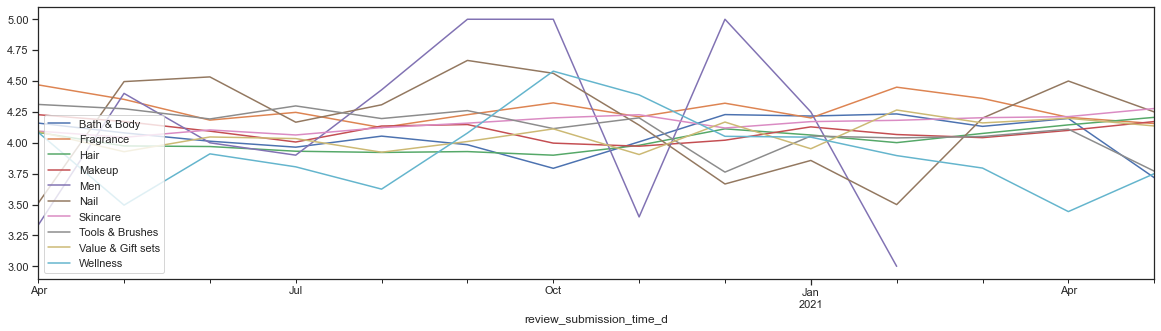

In [378]:
# plt.plot( df_reviews_2021_ts, );
df_reviews_2021_ts.plot()
plt.legend()

<AxesSubplot:xlabel='review_submission_time_d'>

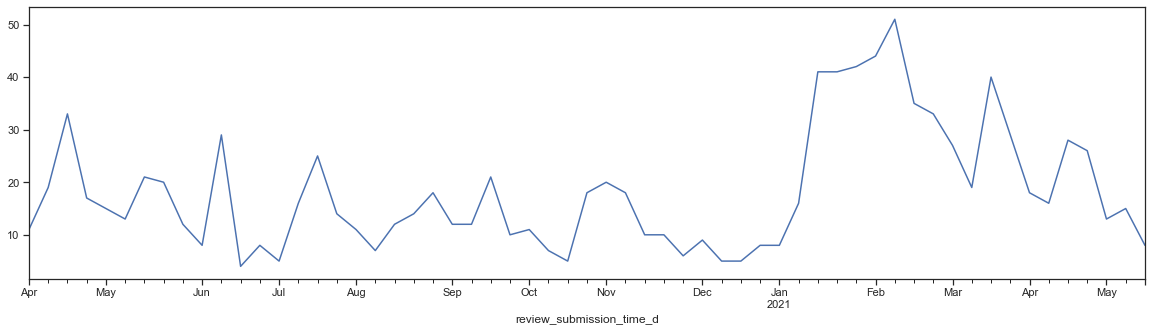

In [379]:
df_reviews_2021.set_index('review_submission_time_d')['ReviewText'].str.lower().str.contains('covid|pandemic|virus').resample('W').sum().plot()

In [380]:
df_covid = df_reviews_2021.set_index(['review_submission_time_d', 'category_level1'])['ReviewText'].str.lower().str.contains('covid|pandemic|virus')

In [381]:
df_covid = df_reviews_2021.set_index(['review_submission_time_d', 'category_level1'])['ReviewText'].str.lower().str.contains('covid|pandemic|virus')

In [382]:
df_covid = pd.DataFrame(df_covid)

In [383]:
df_covid = df_covid.reset_index()

In [384]:
df_covid_product = df_covid.groupby(['review_submission_time_d', 'category_level1'])['ReviewText'].sum().unstack()

In [385]:
df_covid_product

category_level1,Bath & Body,Fragrance,Hair,Makeup,Men,Nail,Skincare,Tools & Brushes,Value & Gift sets,Wellness
review_submission_time_d,,,,,,,,,,
2020-04-01,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0
2020-04-02,0.0,1.0,1.0,1.0,NaN,NaN,1.0,0.0,0.0,0.0
2020-04-03,0.0,0.0,0.0,0.0,NaN,NaN,3.0,0.0,0.0,0.0
2020-04-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-05,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-11,0.0,0.0,1.0,0.0,NaN,0.0,1.0,0.0,0.0,NaN
2021-05-12,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
2021-05-13,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [386]:
df_covid = df_covid.groupby(['review_submission_time_d', 'category_level1'])['ReviewText'].sum().unstack()

<AxesSubplot:xlabel='review_submission_time_d'>

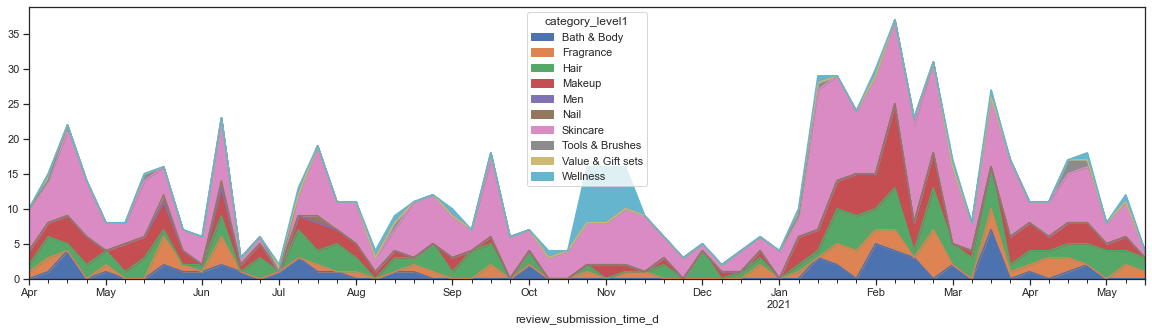

In [387]:
df_covid.resample('W').sum().plot(kind = 'area')

In [388]:
df_covid = df_covid.resample('W').sum()

In [389]:
df_covid['sum'] = df_covid.sum(axis = 1)

In [390]:
df_covid.columns

Index(['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum'],
      dtype='object', name='category_level1')

In [391]:
for i in ['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum']:
    df_covid[i] = df_covid[i]/df_covid['sum']

<AxesSubplot:xlabel='review_submission_time_d'>

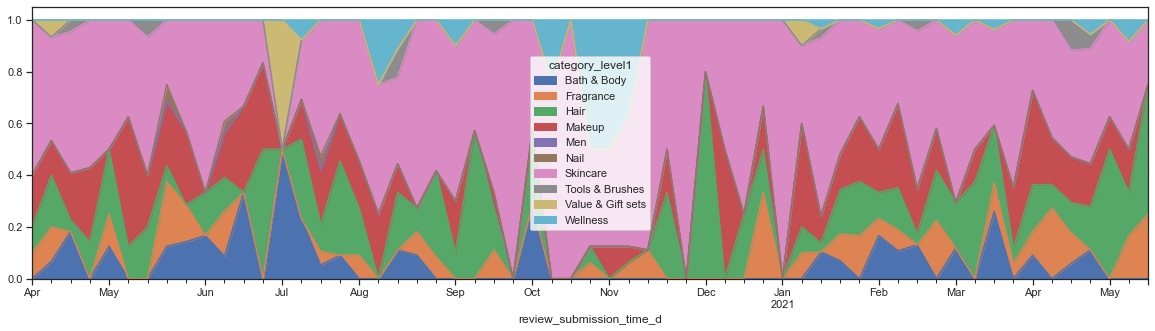

In [392]:
df_covid.iloc[:, :-1].plot(kind = 'area')

# Joy

<AxesSubplot:xlabel='review_submission_time_d'>

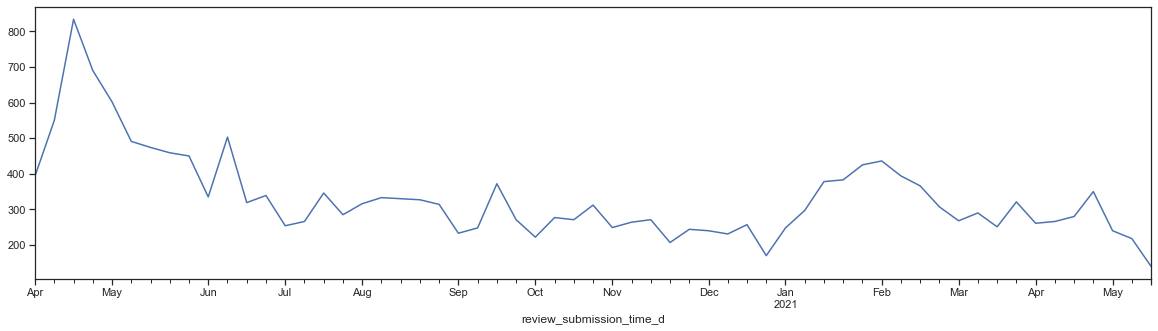

In [393]:
df_reviews_2021.set_index('review_submission_time_d')['ReviewText'].str.lower().str.contains('happy|joy|happiness|relax').resample('W').sum().plot()

In [394]:
df_covid = df_reviews_2021.set_index(['review_submission_time_d', 'category_level1'])['ReviewText'].str.lower().str.contains('happy|joy|happiness|relax')

In [395]:
df_covid = pd.DataFrame(df_covid)

In [396]:
df_covid = df_covid.reset_index()

In [397]:
df_covid = df_covid.groupby(['review_submission_time_d', 'category_level1'])['ReviewText'].sum().unstack()

<AxesSubplot:xlabel='review_submission_time_d'>

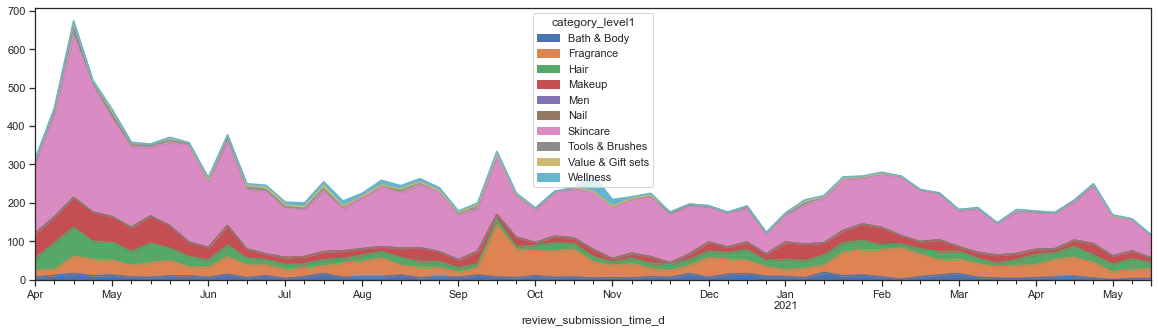

In [398]:
df_covid.resample('W').sum().plot(kind = 'area')

In [399]:
df_covid = df_covid.resample('W').sum()

In [400]:
df_covid['sum'] = df_covid.sum(axis = 1)

In [401]:
df_covid.columns

Index(['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum'],
      dtype='object', name='category_level1')

In [402]:
for i in ['Bath & Body', 'Fragrance', 'Hair', 'Makeup', 'Men', 'Nail', 'Skincare',
       'Tools & Brushes', 'Value & Gift sets', 'Wellness', 'sum']:
    df_covid[i] = df_covid[i]/df_covid['sum']

<AxesSubplot:xlabel='review_submission_time_d'>

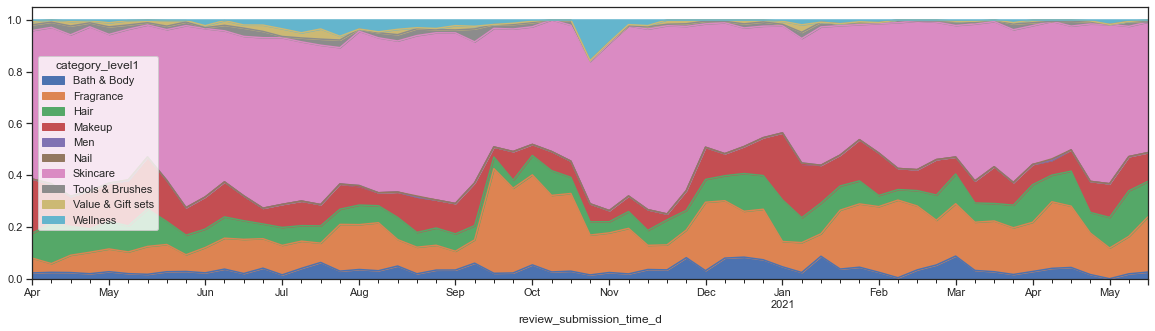

In [403]:
df_covid.iloc[:, :-1].plot(kind = 'area')